# to plate CSY

looking at functiosn to transform from CMM CSY to plate CSY as they differ between new and old code.

In [2]:
import numpy as np

import cmm_error_map.config.config as cf
import cmm_error_map.data_cmpts as dc
import cmm_error_map.mpl_2014.design_matrix_linear as design_old
from cmm_error_map.mpl_2014.ballplate_plots import single_grid_plot

In [3]:
# build matrix directly
def cmm_to_plate_csy_matrix(mmt):
    """
    transform cmm_deform to plate CSY

    origin point ball 0
    z-plane through balls 0, 4, 20
    x-axis through balls 0, 4
    """
    cmm_deform = mmt.cmm_nominal + mmt.cmm_dev
    nx, ny = mmt.artefact.nballs
    xindex = nx - 1
    yindex = nx * (ny - 1)
    xyz0 = cmm_deform[:, 0]
    vx = cmm_deform[:, xindex] - xyz0
    vy = cmm_deform[:, yindex] - xyz0

    vx = vx / np.linalg.norm(vx)
    vy = vy / np.linalg.norm(vy)
    vz = np.cross(vx, vy)
    vz = vz / np.linalg.norm(vz)

    mat = np.array(
        [
            [vx[0], vy[0], vz[0], xyz0[0]],
            [vx[1], vy[1], vz[1], xyz0[1]],
            [vx[2], vy[2], vz[2], xyz0[2]],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

    inv_mat = np.linalg.inv(mat)
    cmm_deform1 = np.vstack((cmm_deform, np.ones((1, nx * ny))))
    mmt_deform = inv_mat @ cmm_deform1

    return mmt_deform[:3, :]

In [4]:
def cmm_to_plate_csy(mmt):
    """
    transform cmm_deform to plate CSY

    origin point ball 0
    z-plane through balls 0, 4, 20
    x-axis through balls 0, 4

    previous code calculating a matrix directly from axis vectors
    suffered from round off errors

    2025-01-20 adding extra rotations to zero z values of corners.
    """

    # transfer to plate CSY
    cmm_deform = mmt.cmm_nominal + mmt.cmm_dev
    cmm_deform1 = np.vstack((cmm_deform, np.ones_like(cmm_deform[0, :])))
    XYZp = np.dot(np.linalg.inv(mmt.transform_mat), cmm_deform1)
    # subtract ball 1 row from each position
    XYZp[:3, :] = XYZp[:3, :] - XYZp[:3, 0:1]
    # also rotate about plate z so y=0 for ball 5
    ang = -1.0 * np.arctan2(XYZp[1, 4], XYZp[0, 4])
    cang = np.cos(ang)
    sang = np.sin(ang)
    RZ = np.array(
        [
            [cang, -sang, 0.0, 0.0],
            [sang, cang, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    XYZp = np.dot(RZ, XYZp)

    mmt_deform = XYZp[:3, :]
    return mmt_deform

In [5]:
def cmm_to_plate_csy_3R(mmt):
    """
    transform cmm_deform to plate CSY

    origin point ball 0
    z-plane through balls 0, 4, 20
    x-axis through balls 0, 4

    previous code calculating a matrix directly from axis vectors
    suffered from round off errors

    2025-01-20 adding extra rotations to zero z values of corners.
    """

    # transfer to plate CSY
    cmm_deform = mmt.cmm_nominal + mmt.cmm_dev
    cmm_deform1 = np.vstack((cmm_deform, np.ones_like(cmm_deform[0, :])))
    XYZp = np.dot(np.linalg.inv(mmt.transform_mat), cmm_deform1)
    # subtract ball 1 row from each position
    XYZp[:3, :] = XYZp[:3, :] - XYZp[:3, 0:1]
    # rotate about plate z so y=0 for ball 5
    ang = -1.0 * np.arctan2(XYZp[1, 4], XYZp[0, 4])
    cang = np.cos(ang)
    sang = np.sin(ang)
    RZ = np.array(
        [
            [cang, -sang, 0.0, 0.0],
            [sang, cang, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    XYZp = np.dot(RZ, XYZp)

    # rotate about plate y so z=0 for ball 5
    ang = 1.0 * np.arctan2(XYZp[1, 4], XYZp[2, 4])
    cang = np.cos(ang)
    sang = np.sin(ang)
    RY = np.array(
        [
            [cang, 0, sang, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [-sang, 0.0, cang, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

    XYZp = np.dot(RY, XYZp)
    mmt_deform = XYZp[:3, :]
    return mmt_deform

In [6]:
def make_mmts():
    """
    return a dict of dc.Measurement
    one for each CMM plane XY, XZ, YZ
    """
    ballspacing = 133.0
    x0, y0, z0 = 250.0, 50.0, 50.0
    # XY plane
    x0xy, y0xy, z0xy = x0, y0, z0
    transform_mat_xy = np.array(
        [
            [1.0, 0.0, 0.0, x0xy],
            [0.0, 1.0, 0.0, y0xy],
            [0.0, 0.0, 1.0, z0xy],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

    xt, yt, zt = 0.0, 0.0, -243.4852
    prb_xy = dc.Probe(title="P0", name="p0", length=np.array([xt, yt, zt]))
    mmt_xy = dc.Measurement(
        title="Plate XY",
        name="mmt_00",
        artefact=cf.artefact_models["KOBA 0620"],
        transform_mat=transform_mat_xy,
        probe=prb_xy,
        cmm_nominal=None,
        cmm_dev=None,
        mmt_nominal=None,
        mmt_dev=None,
    )
    # XZ plane
    x0xz, y0xz, z0xz = x0, y0 + 2.0 * ballspacing, z0
    transform_mat_xz = np.array(
        [
            [1.0, 0.0, 0.0, x0xz],
            [0.0, 0.0, 1.0, y0xz],
            [0.0, 1.0, 0.0, z0xz],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

    xt_xz, yt_xz, zt_xz = 0.0, 130.0, -243.4852
    prb_xz = dc.Probe(title="PXZ", name="pxz", length=np.array([xt_xz, yt_xz, zt_xz]))
    mmt_xz = dc.Measurement(
        title="Plate XZ",
        name="mmt_01",
        artefact=cf.artefact_models["KOBA 0620"],
        transform_mat=transform_mat_xz,
        probe=prb_xz,
        cmm_nominal=None,
        cmm_dev=None,
        mmt_nominal=None,
        mmt_dev=None,
    )
    # YZ plane
    x0yz, y0yz, z0yz = x0 + 2.0 * ballspacing, y0, z0
    transform_mat_yz = np.array(
        [
            [0.0, 0.0, 1.0, x0yz],
            [1.0, 0.0, 0.0, y0yz],
            [0.0, 1.0, 0.0, z0yz],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    xt_yz, yt_yz, zt_yz = 130.0, 0.0, -243.4852
    prb_yz = dc.Probe(title="PYZ", name="pyz", length=np.array([xt_yz, yt_yz, zt_yz]))
    mmt_yz = dc.Measurement(
        title="Plate YZ",
        name="mmt_02",
        artefact=cf.artefact_models["KOBA 0620"],
        transform_mat=transform_mat_yz,
        probe=prb_yz,
        cmm_nominal=None,
        cmm_dev=None,
        mmt_nominal=None,
        mmt_dev=None,
    )

    mmts = {"mmt XY": mmt_xy, "mmt XZ": mmt_xz, "mmt YZ": mmt_yz}
    return mmts


mmt_tests = make_mmts()


In [7]:
model = dc.model_parameters_test.copy()

In [8]:
for mmt in mmt_tests.values():
    mmt.recalculate(model, dc.pmm_866.cmm_model)


In [9]:
mmt_deform_A = cmm_to_plate_csy_matrix(mmt_tests["mmt YZ"])
mmt_deform_B = cmm_to_plate_csy(mmt_tests["mmt YZ"])
mmt_deform_C = cmm_to_plate_csy_3R(mmt_tests["mmt YZ"])

In [10]:
mmt_deform_A[:, 0], mmt_deform_B[:, 0], mmt_deform_C[:, 0]

(array([7.10542736e-15, 7.10542736e-15, 1.13686838e-13]),
 array([0., 0., 0.]),
 array([0., 0., 0.]))

In [11]:
mmt_deform_A[:, 4], mmt_deform_B[:, 4], mmt_deform_C[:, 4]

(array([5.31998335e+02, 7.10542736e-15, 0.00000000e+00]),
 array([ 5.31998335e+02, -1.04371470e-19, -5.85901992e-03]),
 array([-5.31998335e+02, -1.04371470e-19,  5.85901992e-03]))

In [12]:
mmt_deform_A[:, 20], mmt_deform_B[:, 20]

(array([7.10542736e-15, 5.32000073e+02, 1.13686838e-13]),
 array([7.18651456e-03, 5.32000073e+02, 1.77818230e-02]))

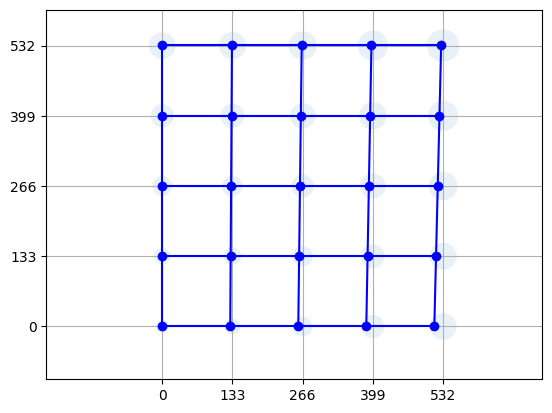

In [13]:
mmt_dev_A = mmt_deform_A - mmt_tests["mmt YZ"].mmt_nominal
single_grid_plot(mmt_dev_A[:-1, :].T, 10000);

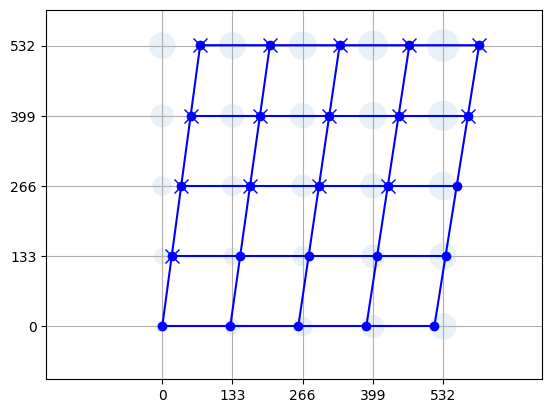

In [14]:
mmt_dev_B = mmt_deform_B - mmt_tests["mmt YZ"].mmt_nominal
single_grid_plot(mmt_dev_B[:-1, :].T, 10000);

In [15]:
def t_matrix(points, corner_inds):
    xyz0 = points[:, corner_inds[0]]
    vx = points[:, corner_inds[1]] - xyz0
    vy = points[:, corner_inds[2]] - xyz0

    vz = np.cross(vx, vy)
    vy = -1 * np.cross(vx, vz)

    vx = vx / np.linalg.norm(vx)
    vy = vy / np.linalg.norm(vy)
    vz = vz / np.linalg.norm(vz)

    mat = np.array(
        [
            [vx[0], vy[0], vz[0], xyz0[0]],
            [vx[1], vy[1], vz[1], xyz0[1]],
            [vx[2], vy[2], vz[2], xyz0[2]],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

    inv_mat = np.linalg.inv(mat)

    return mat, inv_mat

In [16]:
points = np.array([[0, 0, 0], [1, 0.2, 0], [0, 1, 0], [1, 1, 0]]).T
points.shape

(3, 4)

In [17]:
t_matrix(points, [0, 1, 2])

(array([[ 0.98058068, -0.19611614,  0.        ,  0.        ],
        [ 0.19611614,  0.98058068,  0.        ,  0.        ],
        [ 0.        , -0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.98058068,  0.19611614,  0.        ,  0.        ],
        [-0.19611614,  0.98058068,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [18]:
mmt

Measurement(title='Plate YZ', name='mmt_02', artefact=ArtefactType(title='KOBA 0620', nballs=[5, 5], ball_spacing=133.0), transform_mat=array([[  0.,   0.,   1., 516.],
       [  1.,   0.,   0.,  50.],
       [  0.,   1.,   0.,  50.],
       [  0.,   0.,   0.,   1.]]), probe=Probe(title='PYZ', name='pyz', length=array([ 130.    ,    0.    , -243.4852])), cmm_nominal=array([[516., 516., 516., 516., 516., 516., 516., 516., 516., 516., 516.,
        516., 516., 516., 516., 516., 516., 516., 516., 516., 516., 516.,
        516., 516., 516.],
       [ 50., 183., 316., 449., 582.,  50., 183., 316., 449., 582.,  50.,
        183., 316., 449., 582.,  50., 183., 316., 449., 582.,  50., 183.,
        316., 449., 582.],
       [ 50.,  50.,  50.,  50.,  50., 183., 183., 183., 183., 183., 316.,
        316., 316., 316., 316., 449., 449., 449., 449., 449., 582., 582.,
        582., 582., 582.]]), cmm_dev=array([[ 0.0060843 ,  0.00461954,  0.00315479,  0.00169003,  0.00022528,
         0.01052977,  0

In [20]:
mmt.cmm_nominal.max(axis=1)

array([516., 582., 582.])

In [ ]:
mmt_max = mmt.cmm_nominal.max(axis=1)
mmt_min = mmt.cmm_nominal.min(axis=1)
mmt_centre = (mmt_max + mmt_min) / 2
mmt_centre

array([516., 316., 316.])

In [23]:
mmt_min

array([516.,  50.,  50.])

In [24]:
mmt_max

array([516., 582., 582.])

In [28]:
cmm_centre = np.array(dc.pmm_866.cmm_model.size) / 2.0
cmm_centre

array([400., 300., 300.])

In [30]:
mmt_centre - cmm_centre

array([116.,  16.,  16.])